<a href="https://colab.research.google.com/github/Attta-pangestu/crawling-filter-berita/blob/main/prod_crawling_kekeringan_lokasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install requests_cache

In [ ]:
#inisiasi library
import requests
from bs4 import BeautifulSoup
import re
import requests_cache

#inisiasi variabel global
list_berita = []
array_link = []
array_keyword_kabupaten = []
array_keyword_kecamatan = []

# Inisialisasi dictionary untuk menyimpan hasil kumulatif
hasil_kumulatif_kabupaten = {}
hasil_kumulatif_kecamatan = {}

def google_search(query, year_range=None, num_pages=5):
    query = query.replace(" ", "+")
    results_array = []

    for page in range(num_pages):
        start_index = page * 10
        search_url = f"https://www.google.com/search?q={query}&start={start_index}"

        if year_range:
            search_url += f"&tbs=cdr:1,cd_min:{year_range[0]},cd_max:{year_range[1]}"

        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

        response = requests.get(search_url, headers=headers)
        if response.status_code == 200:
            search_results = extract_links_and_titles(response.text)
            results_array.extend(search_results)
        else:
            print(f"Failed to retrieve search results on page {page + 1}. Status code: {response.status_code}")

    return results_array

def extract_links_and_titles(html):
    soup = BeautifulSoup(html, 'html.parser')
    search_results = soup.find_all('div', class_='tF2Cxc')

    results_array = []
    for result in search_results:
        link = result.find('a')['href']
        title = result.find('h3').get_text()
        results_array.append({'title': title, 'link': link})

    list_berita = results_array
    return results_array

def analyze_news_articles(news_articles):
    kabupaten_count = {}
    desa_count = {}

    for article in news_articles:
        title = article['title'].lower()

        if 'kabupaten' in title:
            kabupaten_name = re.search(r'kabupaten (\w+)', title)
            if kabupaten_name:
                kabupaten_name = kabupaten_name.group(1)
                kabupaten_count[kabupaten_name] = kabupaten_count.get(kabupaten_name, 0) + 1

        if 'desa' in title:
            desa_name = re.search(r'desa (\w+)', title)
            if desa_name:
                desa_name = desa_name.group(1)
                desa_count[desa_name] = desa_count.get(desa_name, 0) + 1

    return kabupaten_count, desa_count

def crawlingBerita():
    search_query = input("Masukkan query pencarian (lebih dari satu kalimat): ")
    start_year = input("Masukkan tahun awal filter: ")
    end_year = input("Masukkan tahun akhir filter: ")
    # Meminta input user untuk memilih provinsi berdasarkan nama
    global provinsi_nama_input
    provinsi_nama_input = input("Masukkan nama provinsi yang ingin dijelajahi (masukkan nama resmi : ex Nusa Tenggara Timur):  ")

    if not re.match(r'^\d{4}$', start_year) or not re.match(r'^\d{4}$', end_year):
        print("Format tahun tidak valid. Gunakan format YYYY (contoh: 2020)")
        return

    year_range = (start_year, end_year)

    num_pages = int(input("Masukkan jumlah halaman hasil pencarian yang ingin diambil (1 page for 10 link): "))

    search_results = google_search(search_query, year_range, num_pages)

    if search_results:
        print("\nHasil Pencarian:")
        for i, result in enumerate(search_results, 1):
            print(f"{i}. {result['title']} - {result['link']}")
            array_link.append(result['link'])

        kabupaten_count, desa_count = analyze_news_articles(search_results)

def get_provinsi_data():
    url_provinsi = 'https://wilayah.id/api/provinces.json'
    response_provinsi = requests.get(url_provinsi)

    if response_provinsi.status_code == 200:
        data_provinsi = response_provinsi.json()['data']
        return data_provinsi
    else:
        print(f"Failed to retrieve provinsi data. Status code: {response_provinsi.status_code}")
        return None

def get_kabupaten_data(provinsi_code):
    url_kabupaten = f'https://wilayah.id/api/regencies/{provinsi_code}.json'
    response_kabupaten = requests.get(url_kabupaten)

    if response_kabupaten.status_code == 200:
        data_kabupaten = response_kabupaten.json()['data']
        return data_kabupaten
    else:
        print(f"Failed to retrieve kabupaten data. Status code: {response_kabupaten.status_code}")
        return None

def get_kecamatan_data(kabupaten_code):
    url_kecamatan = f'https://wilayah.id/api/districts/{kabupaten_code}.json'
    response_kecamatan = requests.get(url_kecamatan)

    if response_kecamatan.status_code == 200:
        data_kecamatan = response_kecamatan.json()['data']
        return data_kecamatan
    else:
        print(f"Failed to retrieve kecamatan data. Status code: {response_kecamatan.status_code}")
        return None

def getLokasiArray():
    # Mendapatkan data provinsi
    provinsi_data = get_provinsi_data()

    if provinsi_data:
        # Mendapatkan data provinsi berdasarkan nama
        provinsi_data_input = next((provinsi for provinsi in provinsi_data if provinsi['name'].lower() == provinsi_nama_input.lower()), None)

        if provinsi_data_input:
            # Mendapatkan data kabupaten berdasarkan provinsi
            kabupaten_data = get_kabupaten_data(provinsi_data_input['code'])

            if kabupaten_data:
                # Menampilkan daftar kabupaten
                print("\nDaftar Kabupaten/Kota:")
                global array_keyword_kabupaten
                array_keyword_kabupaten = [kabupaten['name'].replace('Kab.', '').replace('Kota', '').strip() for kabupaten in kabupaten_data]
                print(array_keyword_kabupaten)

                # Mendapatkan data kecamatan dari berbagai kabupaten
                for kabupaten in kabupaten_data:
                    kecamatan_data = get_kecamatan_data(kabupaten['code'])

                    if kecamatan_data:
                        # Menambahkan kecamatan ke list
                        global array_keyword_kecamatan
                        array_keyword_kecamatan.extend([kecamatan['name'] for kecamatan in kecamatan_data])
                    else:
                        print(f"Gagal mendapatkan data kecamatan untuk {kabupaten['name']}")

                # Menampilkan daftar kecamatan yang digabungkan
                print(f"\nDaftar Kecamatan (digabungkan dari berbagai kabupaten):")
                print(array_keyword_kecamatan)

            else:
                print(f"Gagal mendapatkan data kabupaten/kota untuk provinsi {provinsi_nama_input}")

        else:
            print(f"Provinsi dengan nama {provinsi_nama_input} tidak ditemukan.")

def hitung_kemunculan_kata(url, kata_kunci_array):
    try:
        requests_cache.install_cache('my_cache', expire_after=3600)
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

        # Memanfaatkan caching
        with requests_cache.CachedSession() as session:
            # Mendapatkan konten halaman web dengan header
            response = session.get(url, headers=headers)
            response.raise_for_status()  # Raise HTTPError jika respons tidak berhasil

            # Menangani status code yang tidak diinginkan
            if response.status_code != 200:
                print(f"Error saat mengakses {url}. Status code: {response.status_code}")
                return None

            soup = BeautifulSoup(response.text, 'html.parser')

            # Mendapatkan teks dari halaman web
            teks = soup.get_text()

            # Inisialisasi dictionary untuk menyimpan jumlah kemunculan kata kunci
            find_keyword = {}

            # Iterasi melalui setiap kata kunci
            for kata_kunci in kata_kunci_array:
                # Menghitung kemunculan kata kunci
                kemunculan = teks.lower().count(kata_kunci.lower())

                # Jika ditemukan, menyimpan jumlah kemunculan
                if kemunculan > 0:
                    key = f'keyword {kata_kunci.replace("Kab.", "").replace("Kota", "").strip()}'
                    if key in find_keyword:
                        find_keyword[key] += kemunculan
                    else:
                        find_keyword[key] = kemunculan

            return find_keyword

    except requests.exceptions.RequestException as e:
        print(f"Error saat mengakses {url}: {str(e)}")
        return None  # Mengembalikan None untuk menandakan bahwa terjadi kesalahan


In [ ]:

# IMPLEMENTATION

crawlingBerita()
getLokasiArray()

# Iterasi melalui setiap link berita
for link in array_link:
    try:
        hasil_kemunculan_kabupaten = hitung_kemunculan_kata(link, array_keyword_kabupaten)
        hasil_kemunculan_kecamatan = hitung_kemunculan_kata(link, array_keyword_kecamatan)

        # Menambahkan hasil pencarian dari link berita ke hasil kumulatif kabupaten
        for kata_kunci, kemunculan in hasil_kemunculan_kabupaten.items():
            if kata_kunci in hasil_kumulatif_kabupaten:
                hasil_kumulatif_kabupaten[kata_kunci] += kemunculan
            else:
                hasil_kumulatif_kabupaten[kata_kunci] = kemunculan

        # Menambahkan hasil pencarian dari link berita ke hasil kecamatan
        for kata_kunci, kemunculan in hasil_kemunculan_kecamatan.items():
            if kata_kunci in hasil_kumulatif_kecamatan:
                hasil_kumulatif_kecamatan[kata_kunci] += kemunculan
            else:
                hasil_kumulatif_kecamatan[kata_kunci] = kemunculan

    except Exception as e:
        print(f"Error saat memproses link {link}: {str(e)}")

# Menampilkan hasil kumulatif kabupaten
print('Analisis Kumulatif Kabupaten:')
for kata_kunci, kemunculan in hasil_kumulatif_kabupaten.items():
    print(f'{kata_kunci} : {kemunculan} kali')

print('----------------')

# Menampilkan hasil kumulatif kecamatan
print('Analisis Kumulatif Kecamatan:')
for kata_kunci, kemunculan in hasil_kumulatif_kecamatan.items():
    print(f'{kata_kunci} : {kemunculan} kali')


Masukkan query pencarian (lebih dari satu kalimat): kekeringan ntt
Masukkan tahun awal filter: 2020
Masukkan tahun akhir filter: 2023
Masukkan nama provinsi yang ingin dijelajahi (masukkan nama resmi : ex Nusa Tenggara Timur):  nusa tenggara barat
Masukkan jumlah halaman hasil pencarian yang ingin diambil (1 page for 10 link): 2

Hasil Pencarian:
1. Kekeringan Ekstrem di NTT Meluas - https://www.kompas.id/baca/nusantara/2023/09/01/kekeringan-ekstrem-di-ntt-meluas
2. Kekeringan Ekstrem Landa Empat Kabupaten di NTT - https://www.kompas.id/baca/nusantara/2023/08/04/kekeringan-ekstrem-landa-empat-kabupaten-di-ntt
3. NTT Masuk Puncak Musim Kemarau- Berita Pusdalops PB ... - https://bpbd.nttprov.go.id/berita/detail/240/NTT-Masuk-Puncak-Musim-Kemarau
4. Kekeringan di NTT, Warga Diimbau Siaga dan Hati-hati - https://www.rri.co.id/nasional/343710/kekeringan-di-ntt-warga-diimbau-siaga-dan-hati-hati
5. NTB dan NTT Hadapi Bencana Kekeringan - https://www.voaindonesia.com/a/ntb-dan-ntt-hadapi-benca

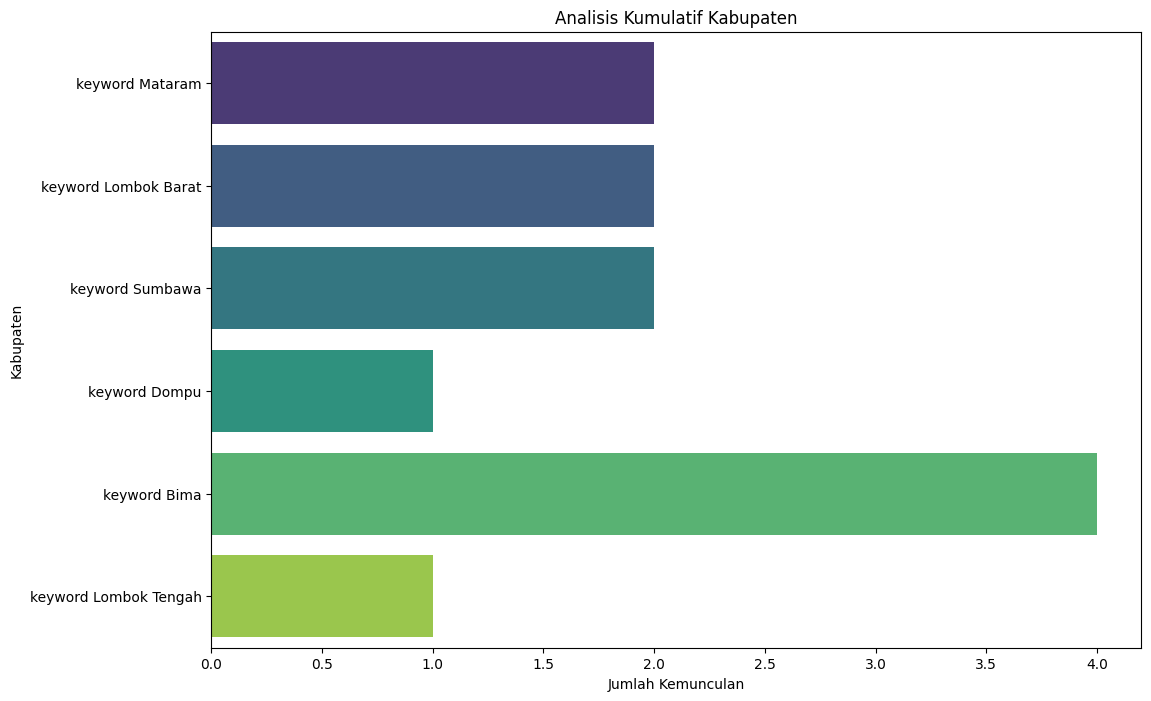

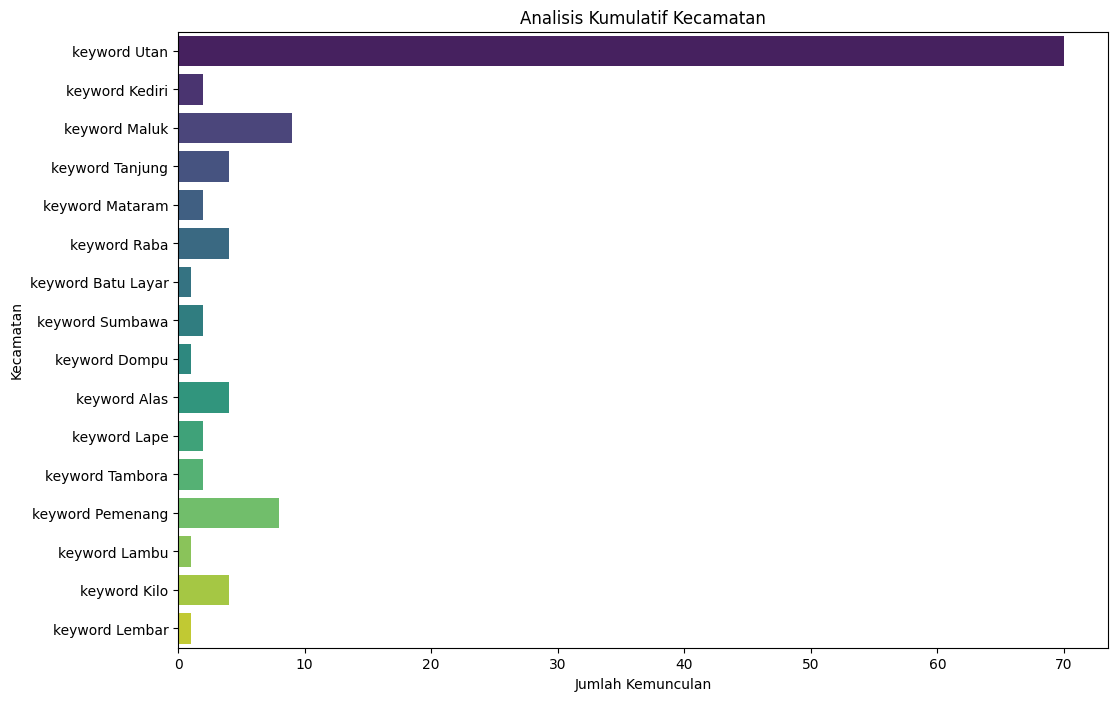

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fungsi untuk menampilkan grafik batang
def plot_bar_chart(data, title, xlabel, ylabel):
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(data.values()), y=list(data.keys()), palette="viridis")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Menampilkan grafik batang untuk analisis kumulatif kabupaten
plot_bar_chart(hasil_kumulatif_kabupaten, 'Analisis Kumulatif Kabupaten', 'Jumlah Kemunculan', 'Kabupaten')

# Menampilkan grafik batang untuk analisis kumulatif kecamatan
plot_bar_chart(hasil_kumulatif_kecamatan, 'Analisis Kumulatif Kecamatan', 'Jumlah Kemunculan', 'Kecamatan')
